### Executive Summary

At Reddit, as a company, we're always looking for ways to increase profit. For this project, my first goal is to create a model that will help improve the user experience. I would then conduct research on how that improvement affects the number of premium accounts. Keep in mind, this is going to be an ongoing project to find a long term solution that will help create a steady growth in profit. The great news is that we are using data that is readily available, which should be more cost effective, and would allow us to quickly implement this change. 

In order to improve user experience, my model will be taking in words from a post to predict which subreddit it belongs to. The user would then get suggestions on related subreddits that they may be interested. Similar to Instagram, when you start following an account, you instantly get requests to follow other related accounts. For this test, I created a model comparing the Travel and Shoestring subreddit. As a reminder, the Shoestring subreddit are for those that like to travel on a budget. 

This falls along the lines of our current strategy, which is to keep users engaged and motivated to be active in subreddits they follow. While the length of time someone spends on a site is important and useful, I'm more interested in knowing whether it increases the number of members to sign up for the Premium services. One of the perks for Premium is to avoid ads, which someone may want after they've been exploring Reddit for a while. As you scroll through the posts, those embedded advertisements can become a hassle and a distraction.

Due to the fact that we are going to be testing and modeling on data between related subreddit topics, differentiating between the two can be quite challenging. Currently, my model is making correct predictions about 73% of the time. While it's relatively good, there are improvements and adjustments that I'd like to make to increase the accuracy score more. 

### Cleaning data and modeling

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn import datasets
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
# Combining all .csv files into one big dataframe for cleaning and modeling
# ref: http://goodbody.io/combining-csv-files-with-glob/

travel_shoestring_df = pd.DataFrame()
columns = ['title', 'posts', 'subreddit']

for f in glob.glob("./Posts csv files/*.csv"):
    df = pd.read_csv(f, usecols = columns, dtype = object)
    travel_shoestring_df = travel_shoestring_df.append(df, ignore_index = True)

travel_shoestring_df

,title,posts,subreddit
0,Traveling to NYC...,I am traveling to NYC in a week. What areas o...,Shoestring
1,Looking for a mini getaway trip.,You’re traveling with your SO this Fall and ha...,Shoestring
2,Emergency travel - Standby ticket?,"Hi everyone,\n\nMy little sister was involved ...",Shoestring
3,Should I ditch my greyhound ticket for a plane...,"So I will be going on a trip soon, it's my fir...",Shoestring
4,"2 weeks in Red Hook Brooklyn, what should we see?",We're pet sitting for a couple of weeks. No ca...,Shoestring
5,Experiencing Andalusia for the first time is a...,NaN,Shoestring
6,January Winter Wonderland European Destinations?,Looking for destinations in Europe including e...,Shoestring
7,Possible the most beautiful natural thermal sp...,NaN,Shoestring
8,Traveling with a baby?,Hi!\nI’d like to take my husband somewhere for...,Shoestring
9,Need help finding a cheap flight,Hello friends. I recently booked a one way tic...,Shoestring


In [3]:
travel_shoestring_df.to_csv("./travel_shoestring_df.csv")

In [4]:
travel_shoestring_df['title_posts'] = travel_shoestring_df['title'] + travel_shoestring_df['posts']

In [5]:
travel_shoestring_df.shape

(1998, 4)

In [6]:
travel_shoestring_df.isnull().sum()

title            0
posts          290
subreddit        0
title_posts    290
dtype: int64

In [7]:
travel_shoestring_df.replace(np.nan, ' ', inplace = True)

In [8]:
travel_shoestring_df.isnull().sum().sum()

0

In [9]:
travel_shoestring_df['subreddit'] = travel_shoestring_df['subreddit'].map(lambda p : 1 if p == "travel" else 0)

### Baseline: 

About 50.3% for Shoestring (set as the negative class)

In [10]:
travel_shoestring_df['subreddit'].value_counts(normalize = True)

0    0.503504
1    0.496496
Name: subreddit, dtype: float64

In [11]:
travel_shoestring_df.head()

,title,posts,subreddit,title_posts
0,Traveling to NYC...,I am traveling to NYC in a week. What areas o...,0,Traveling to NYC...I am traveling to NYC in a...
1,Looking for a mini getaway trip.,You’re traveling with your SO this Fall and ha...,0,Looking for a mini getaway trip.You’re traveli...
2,Emergency travel - Standby ticket?,"Hi everyone,\n\nMy little sister was involved ...",0,"Emergency travel - Standby ticket?Hi everyone,..."
3,Should I ditch my greyhound ticket for a plane...,"So I will be going on a trip soon, it's my fir...",0,Should I ditch my greyhound ticket for a plane...
4,"2 weeks in Red Hook Brooklyn, what should we see?",We're pet sitting for a couple of weeks. No ca...,0,"2 weeks in Red Hook Brooklyn, what should we s..."


In [12]:
travel_shoestring_df.shape

(1998, 4)

In [13]:
travel_shoestring_df.drop_duplicates(inplace = True)

In [14]:
travel_shoestring_df.shape

(1797, 4)

In [15]:
travel_shoestring_df['title_posts']

0       Traveling to NYC...I am traveling to NYC  in a...
1       Looking for a mini getaway trip.You’re traveli...
2       Emergency travel - Standby ticket?Hi everyone,...
3       Should I ditch my greyhound ticket for a plane...
4       2 weeks in Red Hook Brooklyn, what should we s...
5                                                        
6       January Winter Wonderland European Destination...
7                                                        
8       Traveling with a baby?Hi!\nI’d like to take my...
9       Need help finding a cheap flightHello friends....
10      Megabus ticket sales for the fallanyone have a...
11      Costa Rica/Central AmericaHi All!\n\nI will be...
12      Airlines Cracking Down on Carry-On Bag Sizes?J...
13      AmsterdamHiya,  \n\n\nI don't normally do the ...
14      First Solo Trip to JapanHi. I’m making my firs...
15      Flights to AustraliaMe and my girlfriend are p...
16      RICHMOND, VA TO LAS VEGAS, NV: October 24-Nove...
17      Vacati

In [117]:
# ref adi's project demo in DC Flex for cleaning data using lambda & removing subreddit names
# got 1st three regex codes from lectures and https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python

import regex as re

travel_shoestring_df['title_posts'] = travel_shoestring_df.title_posts.map(lambda x: re.sub(" \d+", " ", x))
travel_shoestring_df['title_posts'] = travel_shoestring_df.title_posts.map(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', ' ', x))
travel_shoestring_df['title_posts'] = travel_shoestring_df.title_posts.map(lambda x: re.sub("[^a-zA-Z]", " ", x))
travel_shoestring_df['title_posts'] = travel_shoestring_df.title_posts.map(lambda x: re.sub('(travel|shoestring|subreddit|reddit)[s]?', ' ', x,  flags=re.I))



In [17]:
# This had a link in the text, so double checking to make sure it was removed

travel_shoestring_df['title_posts'].iloc[806]

'r   Region of the Week   Wallonia Hey  lers    In this new series of weekly threads we want to focus on regions that have a lot to offer to  lers  the towns  nature  and other interesting places whether they are lesser or more known  If more known provide more in depth suggestions like tours  things to do  places to eat  etc    Please contribute all and any questions   thoughts   suggestions   ideas   stories   highlights about this   destination  whether it be places you want to see or experiences you have had   This post will be  archived on our wiki destinations page  http   www   com r   wiki topic of the week  and linked in the sidebar for future reference  so please direct any of the more  repetitive questions  http   www   com r   search q  Indonesia  self  Ayes amp restrict sr on amp sort relevance amp t all  there  Please cick  here   https   docs google com spreadsheets d  RX YnlJHWfAFBv  oZZha d S BxXLGHUvnDqbOju k edit usp sharing  for list and dates of future destinations

In [192]:
# used this to check if the removed terms were still in the text

for x in travel_shoestring_df['title_posts']:
    if "shoestring" in x:
        print(x)
        
for i in travel_shoestring_df['title_posts']:
    if "travel" in i:
        print(i)

In [193]:
X = travel_shoestring_df['title_posts']
y = travel_shoestring_df['subreddit']

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [197]:
# Want to ignore words that appear in more than 95% of the documents and less than 5 documents
# Using max and min document frequency parameters

tfidfvect = TfidfVectorizer(analyzer = "word", stop_words='english', max_features=300)

In [198]:
X_train_tfidfvect_df = pd.DataFrame(tfidfvect.fit_transform(X_train).toarray(),
                   columns=tfidfvect.get_feature_names())


X_test_tfidfvect_df = pd.DataFrame(tfidfvect.transform(X_test).toarray(),
                   columns=tfidfvect.get_feature_names())

In [199]:
type(tfidfvect.get_feature_names())

list

In [200]:
X_test_tfidfvect_df.shape

(450, 300)

In [84]:
tfidfvect.get_feature_names()

['able',
 'accommodation',
 'activities',
 'actually',
 'advance',
 'advice',
 'air',
 'airbnb',
 'airline',
 'airlines',
 'airport',
 'amazing',
 'america',
 'american',
 'amp',
 'amsterdam',
 'appreciated',
 'area',
 'arrive',
 'asia',
 'ask',
 'aug',
 'august',
 'avoid',
 'bag',
 'barcelona',
 'beach',
 'best',
 'better',
 'big',
 'bit',
 'book',
 'booked',
 'booking',
 'bring',
 'budget',
 'bus',
 'buy',
 'canada',
 'car',
 'card',
 'carry',
 'central',
 'cheap',
 'cheaper',
 'cheapest',
 'check',
 'checked',
 'china',
 'cities',
 'city',
 'close',
 'coast',
 'com',
 'considering',
 'cool',
 'cost',
 'countries',
 'country',
 'couple',
 'currently',
 'day',
 'days',
 'dc',
 'deal',
 'decided',
 'definitely',
 'destination',
 'destinations',
 'did',
 'didn',
 'different',
 'does',
 'doesn',
 'doing',
 'don',
 'drive',
 'driving',
 'early',
 'eat',
 'edit',
 'end',
 'enjoy',
 'europe',
 'expensive',
 'experience',
 'experiences',
 'explore',
 'family',
 'far',
 'feel',
 'flight',
 'f

### Logistic Regression model

This model had the best accuracy score.

In [216]:
lr = LogisticRegression(penalty = 'l1')
lr.fit(X_train_tfidfvect_df, y_train)

/Users/jmiger/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [217]:
lr.score(X_train_tfidfvect_df, y_train)

0.7557535263548627

In [218]:
lr.score(X_test_tfidfvect_df, y_test)

0.7311111111111112

In [220]:
# cross_val_score and lr.score for test data were both around 70.6%, while score for training data was around 78%.
    # conclusion: I don't have a bad sample, just need to do some tuning
    # Changing the default penalty to Lasso, improved the model

cross_val_score(lr, X_train_tfidfvect_df, y_train, cv = 5).mean()

/Users/jmiger/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jmiger/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jmiger/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jmiger/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jmiger/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

0.7023474737012994

In [269]:
lr.coef_.mean()

-0.011015019672314063

In [270]:
# As X (# of occurances for a word/feature) increases 1 unit, a post is about 0.99 times as likely 
    #to be from the travel subreddit
np.exp(-0.011015019672314063)

0.9890454235256434

### Naive Bayes model

Tried Gaussian because the values are floats, but Multinomial is the better classifier (maybe slighltly overfit). It treats values from a TFIDF vectorizer the same as those from Count vectorizer. Also, Multinomial score is better.

In [42]:
gausnb = GaussianNB()

In [43]:
gausnb.fit(X_train_tfidfvect_df, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [274]:
cross_val_score(gausnb, X_train_tfidfvect_df, y_train, cv = 5).mean()

0.660069992869194

In [44]:
gausnb.score(X_train_tfidfvect_df, y_train)

0.755011135857461

In [45]:
# close to the cross val score for 
gausnb.score(X_test_tfidfvect_df, y_test)

0.6644444444444444

In [221]:
nb = MultinomialNB()

In [223]:
multi = nb.fit(X_train_tfidfvect_df, y_train)

In [236]:
pred = multi.predict(X_test_tfidfvect_df)

In [273]:
cross_val_score(multi, X_train_tfidfvect_df, y_train, cv = 5).mean()

0.7075464067518663

In [237]:
multi.score(X_train_tfidfvect_df, y_train)

0.7616926503340757

In [238]:
multi.score(X_test_tfidfvect_df, y_test)

0.6955555555555556

In [239]:
from sklearn.metrics import confusion_matrix

In [259]:
cm = confusion_matrix(y_test, pred)

In [271]:
# It looks like my model has incorrectly predicted the Shoestring subreddit more than it correctly predicted it.
# It was must better and predicting for travel

cm_df = pd.DataFrame(cm,
             columns=['pred shoestring', 'pred travel'],
            index = ['actual shoestring', 'actual travel'])
cm_df

,pred shoestring,pred travel
actual shoestring,97,105
actual travel,32,216


### Random Forest Classifier

Not as good as the logistic model, but also not extremely overfit. The cross val score and the accuracy score is pretty close to each other, which would mean that my sample isn't bad. I would like to attempt adjusting the parameters some more until I get optimal results. 

In [243]:
rf = RandomForestClassifier(random_state=42)

In [244]:
cross_val_score(lr, X_train_tfidfvect_df, y_train, cv = 5).mean()

/Users/jmiger/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jmiger/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jmiger/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jmiger/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jmiger/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

0.7023474737012994

In [246]:
params = {
    'n_estimators': [50, 100],
    'max_depth' : [8, 10],
    'min_samples_leaf' : [2, 3]
}

gs = GridSearchCV(rf, param_grid=params, return_train_score=True, cv=5)
gs.fit(X_train_tfidfvect_df, y_train)
print(gs.score(X_train_tfidfvect_df, y_train))
gs.best_params_

0.7676317743132888


{'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 100}

In [247]:
gs.score(X_test_tfidfvect_df, y_test)

0.7022222222222222

In [258]:
cross_val_score(rf, X_train_tfidfvect_df, y_train, cv = 5).mean()

/Users/jmiger/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jmiger/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jmiger/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jmiger/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Use

0.6541054537309323

In [248]:
gs.best_estimator_.feature_importances_

array([3.03106311e-03, 7.96189416e-04, 9.99674280e-04, 0.00000000e+00,
       2.51294228e-03, 2.89421291e-03, 0.00000000e+00, 7.67342039e-04,
       2.03116811e-04, 5.69434981e-04, 1.65342600e-03, 0.00000000e+00,
       2.91172831e-04, 2.11273783e-04, 3.40643795e-03, 4.36471941e-05,
       2.33918616e-03, 3.38839167e-04, 2.67912004e-03, 4.13212031e-04,
       2.13490787e-03, 1.93835148e-03, 2.78470701e-06, 0.00000000e+00,
       0.00000000e+00, 6.69018886e-04, 7.52384756e-04, 1.21695945e-02,
       1.06420844e-03, 1.85584810e-03, 5.92971034e-03, 8.74596150e-04,
       5.15489417e-04, 3.57474958e-04, 8.60333570e-04, 5.76815256e-02,
       3.24100102e-03, 1.01665926e-03, 2.64890700e-05, 1.70632340e-03,
       1.86958318e-03, 3.39637586e-04, 5.70808014e-04, 1.28739351e-01,
       2.60747311e-02, 4.86469927e-02, 2.21248558e-04, 0.00000000e+00,
       0.00000000e+00, 2.02288361e-03, 2.54472630e-03, 2.33196620e-04,
       1.23124894e-04, 3.15312827e-03, 3.38084131e-04, 8.27382419e-04,
      

In [249]:
feat_ratings = pd.DataFrame(gs.best_estimator_.feature_importances_, X_train_tfidfvect_df.columns, columns=['importance'])

In [257]:
# most important features on the top

feat_ratings.sort_values(by = 'importance', ascending = False)

,importance
cheap,0.128739
budget,0.057682
cheapest,0.048647
itinerary,0.028247
cheaper,0.026075
time,0.025341
save,0.023941
day,0.022778
tips,0.022083
june,0.021529


In [272]:
# least important features on the top

feat_ratings.sort_values(by = 'importance', ascending = True)

,importance
near,0.000000
checked,0.000000
china,0.000000
national,0.000000
mexico,0.000000
luggage,0.000000
living,0.000000
bag,0.000000
avoid,0.000000
years,0.000000


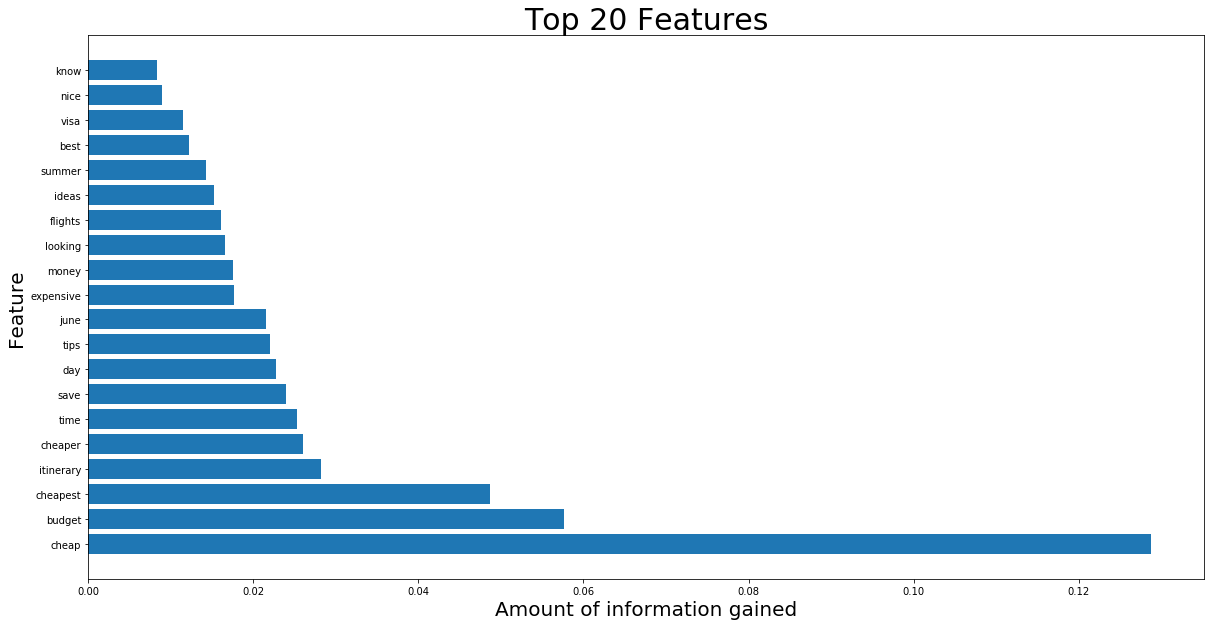

In [251]:
plt.figure(figsize=(20,10))
temp = feat_ratings.sort_values('importance', ascending=False).head(20)
plt.barh(temp.index, temp['importance'])
plt.title('Top 20 Features', fontsize=30)
plt.xlabel('Amount of information gained', fontsize=20)
plt.ylabel('Feature', fontsize=20);